# RGB2DEPTH

🎥 Your camera can understand depth - no LiDAR, no stereo, just pixels. Using the Depth Anything model, a simple RGB video can be turned into a depth map!

**What’s happening under the hood?**

✅ A Vision Transformer (ViT) pretrained on huge image datasets learns spatial geometry almost for free

✅ A lightweight decoder converts those features into dense depth predictions

✅ It works on any image or video - from city scenes to random phone footage

✅ The result is like giving your camera a sense of space and distance

Depth estimation is one of those "quiet revolutions" in vision, which bridges 2D perception and 3D understanding!

Import libraries

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import error: No module named 'triton'


Run RGB2DEPTH pipeline on an image

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


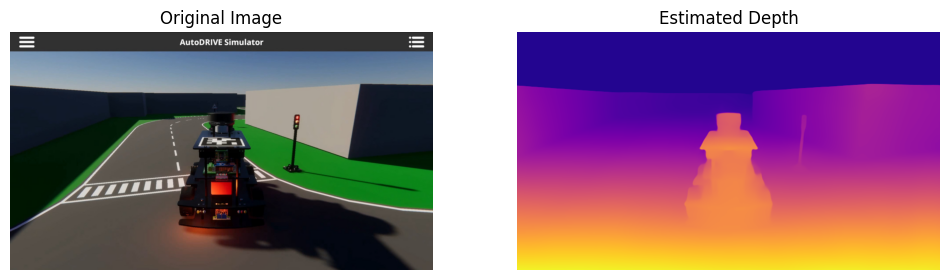

In [2]:
# Read image
image_path = "rgb_input.jpg"
image = Image.open(image_path)

# Configure the model
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# Prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

# Model prediction
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# Convert tensor to numpy
depth = prediction.squeeze().cpu().numpy()

# Normalize for visualization
depth_min, depth_max = depth.min(), depth.max()
depth_normalized = (depth - depth_min) / (depth_max - depth_min)

# Show the input and output side-by-side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(depth_normalized, cmap="plasma")
plt.title("Estimated Depth")
plt.axis("off")
plt.show()

# Save the output
plt.imsave("depth_output.jpg", depth_normalized, cmap="plasma")

Run RGB2DEPTH pipeline on a video

In [3]:
# Configure the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "LiheYoung/depth-anything-small-hf"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForDepthEstimation.from_pretrained(model_name).to(device)
model.eval()

# Video paths
input_path = "rgb_input.mp4" # Original video
output_path = "depth_output.mp4" # Output video

# Extract input video properties
cap = cv2.VideoCapture(input_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Configure video writer to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Loop through the frames
with torch.no_grad():
    for _ in tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))), desc="Processing video"):
        ret, frame = cap.read()
        if not ret:
            break

        # Converte to PIL and process the frame
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Model prediction
        outputs = model(**inputs)
        depth = outputs.predicted_depth

        # Interpolate to the original frame size
        depth_resized = torch.nn.functional.interpolate(
            depth.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

        # Normalize and convert to 8 bits (0–255)
        depth_norm = (depth_resized - depth_resized.min()) / (depth_resized.max() - depth_resized.min())
        depth_colored = (plt.cm.plasma(depth_norm)[..., :3] * 255).astype(np.uint8)
        depth_bgr = cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR)

        out.write(depth_bgr)

# Clean everything
cap.release()
out.release()
print(f"✅ Depth video saved in: {output_path}")

Processing video: 100%|██████████| 184/184 [00:37<00:00,  4.87it/s]

✅ Depth video saved in: depth_output.mp4
